Import the libraries

In [321]:
import collections
from ortools.sat.python import cp_model
import math

Define data for problem

In [322]:
import json
with open('/Users/martintin/Desktop/hayday/hayday_goods_with_storage.json','r') as file:
    raw_data = json.load(file)

with open('my_machines.json','r') as file:
    my_machines = json.load(file)

with open('my_goods.json','r') as file:
    my_goods = json.load(file)

with open('my_storage.json','r') as file:
    my_storage = json.load(file)

BARN_CAPACITY= my_storage['Barn']
SILO_CAPACITY = my_storage['Silo']

all_machines = []

for item_name, details in raw_data.items():
    if(details['machine'] not in all_machines):
        all_machines.append(details['machine'])

machines_count = len(all_machines)

declare the model

In [323]:
model = cp_model.CpModel()

In [324]:
class Task:
    def __init__(self,id, name, start, end, machine, l_presences, parent):
        self.id = id
        self.name = name
        self.start = start
        self.end = end
        self.machine = machine
        self.l_presences = l_presences
        self.parent = parent
        self.children = []
        self.is_active = model.new_bool_var("is_active"+str(id))
        self.removed_explicit = model.new_bool_var("removed"+str(id))
        

goods_data = ['Diamond ring']#martin

machine_to_intervals = collections.defaultdict(list)



horizon = 10000                                                                           
id = 0
queue = []
all_tasks = []

Define the variables

In [325]:

for good in goods_data:
    queue.append((good, id,-1))
    id += 1

while len(queue) != 0:
    current_name, current_id, parent_id = queue.pop(0)
    print(current_name)
    print(raw_data[current_name])
    start_var = model.new_int_var(0,horizon,"start"+str(current_id))
    end_var = model.new_int_var(0,horizon,"end"+str(current_id))
   
    interval_var = model.new_interval_var(
        start_var, raw_data[current_name]['time'], end_var, "interval"+str(current_id)
    )
    machine_var = model.new_int_var(0,len(all_machines),"machine"+str(current_id))
    
    l_presences = []
    num_specific_my_machines = my_machines[raw_data[current_name]['machine']]['number']
    for i in range(num_specific_my_machines):
        l_start_var = model.new_int_var(0,horizon,"l_start"+ str(i)+str(current_id))
        l_end_var = model.new_int_var(0,horizon,"l_end"+str(i)+str(current_id))
        l_presence_var = model.new_bool_var(f"l_presence{str(i)}_{str(current_id)}")
        l_interval_var = model.new_optional_interval_var(
            l_start_var, raw_data[current_name]['time'], l_end_var, l_presence_var, "interval"+str(current_id)
        )
        
        model.Add(start_var == l_start_var).OnlyEnforceIf(l_presence_var)
        model.Add(end_var == l_end_var).OnlyEnforceIf(l_presence_var)
        model.Add(machine_var == i).OnlyEnforceIf(l_presence_var)
        l_presences.append(l_presence_var)
        machine_to_intervals[raw_data[current_name]['machine']+str(i)].append(l_interval_var)
    model.add_exactly_one(l_presences)

    t = Task(id,current_name,start_var,end_var,machine_var,l_presences,parent_id)
    all_tasks.append(t)
    if(parent_id != -1):
        all_tasks[parent_id].children.append(t)
        model.add(
            all_tasks[parent_id].start >= all_tasks[current_id].end
        ).only_enforce_if(all_tasks[parent_id].is_active, all_tasks[current_id].is_active)
        model.add_implication(all_tasks[parent_id].is_active.Not(),all_tasks[current_id].is_active.Not())
        model.add_bool_and(
            all_tasks[current_id].is_active.Not(),
            all_tasks[parent_id].is_active
        ).OnlyEnforceIf(all_tasks[current_id].removed_explicit)

        model.add_bool_or(
            all_tasks[current_id].is_active,
            all_tasks[parent_id].is_active.Not()
        ).OnlyEnforceIf(all_tasks[current_id].removed_explicit.Not())
    else:
        model.add(all_tasks[current_id].removed_explicit == all_tasks[current_id].is_active.Not())

    
    
    for ing, ing_qty in raw_data[current_name]['ingredients'].items():
        if(ing != current_name):
            temp = []
            for i in range(ing_qty):
                queue.append((ing, id, current_id))
                id += 1
                


Diamond ring
{'ingredients': {'Diamond': 1, 'Gold bar': 2, 'Platinum bar': 2}, 'time': 240, 'xp': 98, 'machine': 'Jeweler', 'storage': 'barn'}
Diamond
{'ingredients': {}, 'time': 0, 'xp': 0, 'machine': '', 'storage': 'silo'}


KeyError: ''

Define the constraints

In [ ]:
for task in all_tasks:
        temp_arr = []
        inactive_parents = []
        for t in all_tasks:
            if(t.name == task.name):
                temp_arr.append(t.removed_explicit)
                inactive_parents.append(all_tasks[t.parent].is_active.Not())
        if(task.name in my_goods):
            if(int(my_goods[task.name]['number']) > 0):
                num_of_inactive_parents = sum(inactive_parents)
                min_var = model.NewIntVar(0, 10000, 'min_var')
                if(task.parent != -1):
                    model.AddMinEquality(min_var, [len(temp_arr)-num_of_inactive_parents, my_goods[task.name]['number']])
                else:
                    model.AddMinEquality(min_var, [len(temp_arr), my_goods[task.name]['number']])

                model.Add(sum(temp_arr) == min_var)
            else:
                model.Add(sum(temp_arr) == 0)
        else:
            model.Add(sum(temp_arr) == 0)
    

import re

def get_trailing_number(s):
    match = re.search(r'\d+$', s)
    if match:
        return int(match.group(0)) 
    else:
        return None

for machine in machine_to_intervals.keys():
    model.add_no_overlap(machine_to_intervals[machine])

for machine in machine_to_intervals.keys():
    intervals = machine_to_intervals[machine]
    for i in intervals:
        for j in intervals:
            if(i != j):
                id_i = int(i.Name()[len("interval"):])
                id_j = int(j.Name()[len("interval"):])

                good_i = all_tasks[id_i].name
                good_j = all_tasks[id_j].name

                a =  model.NewBoolVar('a')
                model.add(all_tasks[id_j].start >= all_tasks[id_i].end).OnlyEnforceIf(a)
                model.add(all_tasks[id_j].start < all_tasks[id_i].end).OnlyEnforceIf(a.Not())
                
                b = model.NewBoolVar('b')
                model.add(all_tasks[id_i].start >= all_tasks[id_j].end).OnlyEnforceIf(b)
                model.add(all_tasks[id_i].start < all_tasks[id_j].end).OnlyEnforceIf(b.Not())
                
                model.AddBoolOr(a,b).OnlyEnforceIf(all_tasks[id_i].l_presences[get_trailing_number(machine)],all_tasks[id_j].l_presences[get_trailing_number(machine)])

times = []
for task in all_tasks:
    times.append(task.end)

storage = []

#is_completed[time index][silo, barn][task index]

#sum(storage[time index][0])


initial_silo_storage = 0
initial_barn_storage = 0 

initial_silo_storage_used = []
initial_barn_storage_used = []

sum(item["number"] for item in my_goods.values())
for good in my_goods:
    if(raw_data[good]['storage'] == "barn"):
        initial_barn_storage += my_goods[good]['number']
    elif(raw_data[good]['storage'] == 'silo'):
        initial_silo_storage += my_goods[good]['number']
print(initial_barn_storage)
print(initial_silo_storage)
for i in range(len(times)):
    silo_temp_arr = []
    barn_temp_arr = []
    
    for j in range(len(all_tasks)):
        temp = model.NewBoolVar(str(i)+"_"+str(j))
        # 1. Create a boolean variable for the parent task ending on time
        end_on_time = model.NewBoolVar(f'end_on_time_{i}_{j}')
        model.add(all_tasks[j].end <= times[i]).OnlyEnforceIf(end_on_time)
        model.add(all_tasks[j].end > times[i]).OnlyEnforceIf(end_on_time.Not())

        #if parent != -1, if removed_explict and parent start time is less than times[i] then add 1 to initial_storage_used
        if(len(raw_data[all_tasks[j].name]['ingredients']) == 0 ):
            model.add(all_tasks[j].removed_explicit == 1)
            
        if(all_tasks[j].parent != -1):
            parent_not_started = model.NewBoolVar(f'parent_not_started_{i}_{j}')
            model.add(all_tasks[all_tasks[j].parent].start >= times[i]).OnlyEnforceIf(parent_not_started)
            model.add(all_tasks[all_tasks[j].parent].start < times[i]).OnlyEnforceIf(parent_not_started.Not())

            model.AddBoolAnd([parent_not_started, end_on_time]).OnlyEnforceIf(temp)
            model.AddBoolOr([parent_not_started.Not(), end_on_time.Not()]).OnlyEnforceIf(temp.Not())

            a = model.NewBoolVar('arent_not_started_{i}_{j}')

            model.AddBoolAnd([all_tasks[j].removed_explicit,parent_not_started.Not()]).OnlyEnforceIf(a)
            model.AddBoolOr([all_tasks[j].removed_explicit.Not(),parent_not_started]).OnlyEnforceIf(a.Not())

            if(raw_data[all_tasks[j].name]['storage'] == "barn"):
                initial_barn_storage_used.append(a)
            elif(raw_data[all_tasks[j].name]['storage']  == "silo"):
                initial_silo_storage_used.append(a)

        else:
            temp = end_on_time

        if(raw_data[all_tasks[j].name]['storage'] == "barn"):
            barn_temp_arr.append(temp)
        elif(raw_data[all_tasks[j].name]['storage']  == "silo"):
            silo_temp_arr.append(temp)

    if barn_temp_arr:
        model.Add(sum(barn_temp_arr) + initial_barn_storage - sum(initial_barn_storage_used) <= BARN_CAPACITY)
    if silo_temp_arr:
        model.Add(sum(silo_temp_arr) + initial_silo_storage - sum(initial_silo_storage_used)  <= SILO_CAPACITY)

    storage.append([silo_temp_arr, barn_temp_arr])



0
1
fuck 3


Define the objective

In [ ]:

obj_var = model.new_int_var(0, horizon, "makespan")

cand_ends = []
for i in range(id):
        c = model.NewIntVar(0, horizon, f"cand_end_{i}") 
        model.Add(c == 0).only_enforce_if(all_tasks[i].is_active.Not())
        model.Add(c == all_tasks[i].end).only_enforce_if(all_tasks[i].is_active)
        cand_ends.append(c)

# 2) now max over those “masked” ends
model.AddMaxEquality(obj_var, cand_ends)
model.minimize(obj_var)

Invoke solver

In [ ]:
solver = cp_model.CpSolver()

  
status = solver.solve(model)

print(solver.Value(obj_var))


2040


Display results

2040 0 1


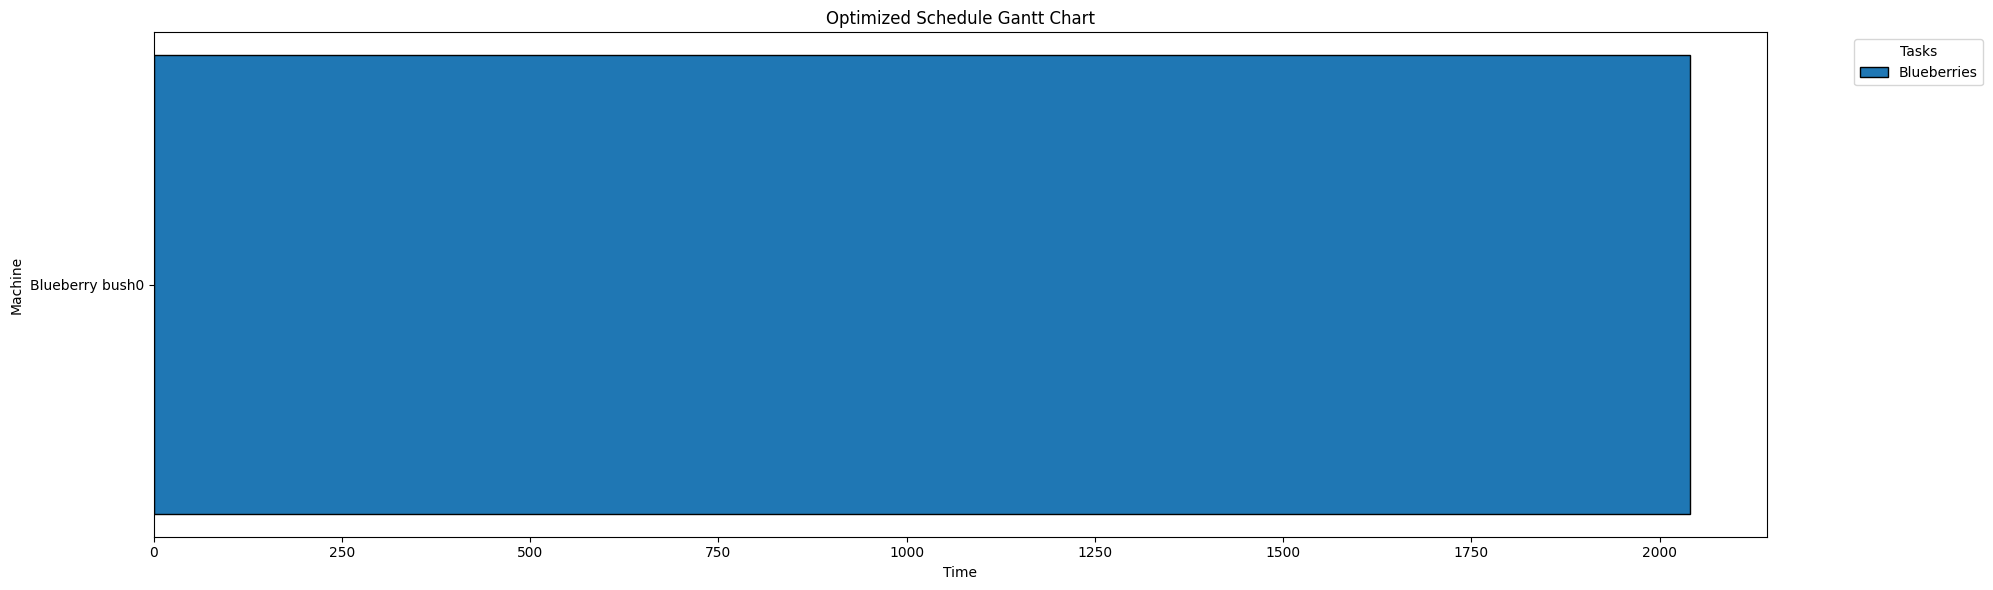

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    # Collect schedule data for plotting
    for i in range(len(times)):
        barn_arr = []
        silo_arr = []
        for j in storage[i][0]:
            silo_arr.append(solver.Value(j))
        for j in storage[i][1]:
            barn_arr.append(solver.Value(j))
        print(str(solver.Value(times[i])),    str(  sum(silo_arr)    )     ,str(  sum(barn_arr)    )       )
     
    schedule_data = []
    for i in range(id):
        if(solver.Value(all_tasks[i].is_active)):
            start = solver.Value(all_tasks[i].start)
            end = solver.Value(all_tasks[i].end)
            machine = raw_data[all_tasks[i].name]['machine']+ str(solver.Value(all_tasks[i].machine))
            schedule_data.append((all_tasks[i].name, start, end, machine))
     
    fig, ax = plt.subplots(figsize=(20, 6))  # Wider figure for visibility

    # Unique machine list and positions
    machines = sorted(set(item[3] for item in schedule_data))
    y_positions = {machine: idx for idx, machine in enumerate(machines)}

    # Assign colors by task name
    colors = {}
    for idx, (task_name, _, _, _) in enumerate(schedule_data):
        if task_name not in colors:
            colors[task_name] = plt.cm.tab20(len(colors) % 20)

    # Draw bars with scaling
    for task_name, start, end, machine in schedule_data:
        ax.barh(
            y_positions[machine],
            (end - start),
            left=start,
            color=colors[task_name],
            edgecolor='black'
        )

    # Create legend
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=task)
                       for task, color in colors.items()]
    ax.legend(handles=legend_elements, title="Tasks", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Format chart
    ax.set_yticks(range(len(machines)))
    ax.set_yticklabels(machines)
    ax.set_xlabel(f"Time")
    ax.set_ylabel("Machine")
    ax.set_title("Optimized Schedule Gantt Chart")
    plt.tight_layout()
    plt.show()
else:
    print("frick")


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


2025-08-07 22:15:00.196 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-07 22:15:00.196 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-07 22:15:00.197 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-07 22:15:00.197 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-07 22:15:00.201 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-07 22:15:00.201 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-07 22:15:00.202 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-07 22:15:00.287 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar